In [ ]:
#COMP5329 2021 Sem 1 Assignment 1 - Jesse Serina Narvasa(500525438), Patrick McLennan (500448953) & Sushmita Shrikrishna Jadhav(500393860)

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# Load datasets
train_data = np.load("/train_data.npy")
train_label = np.load("/train_label.npy")
test_data = np.load("/test_data.npy")
test_label = np.load("/test_label.npy")

#Check shape
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

Mounted at /content/drive
(50000, 128)
(50000, 1)
(10000, 128)
(10000, 1)


In [3]:
class Activation:
    '''
    An Activation object for the purposes of calling Activation functions and their respective derivatives in the MLP.

    Attributes:
    None
    '''

    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        #where a = np.tanh(x)
        return 1.0 - a**2
        
    def __logistic(self, x):
        return 1.0 /(1.0 + np.exp(-x))
    
    def __logistic_deriv(self, a):
        #where a = logistic(x)
        return a * (1-a)
        
    def __relu(self,x):
        return np.maximum(0,x)
  
    def __relu_deriv(self,a):
        return np.heaviside(a, 0)

    def __softmax(self, z):
        z = np.atleast_2d(z)
        max_z = np.max(z, axis=1)
        z = [z[i] - max_z[i] for i in range(max_z.shape[0])] # Numerical Stability
        z = np.array(z)
        return np.divide(np.exp(z).T, np.sum(np.exp(z), axis=1)).T

    def __softmax_deriv(self, y, y_hat):
        return y_hat - y

    #Initialise & set the default activation functions
    def __init__(self, activation = 'relu'):

        '''
        The initialisation of the Activation

        Parameters:
        activation (string): the selected activation function. Set to ReLU by default.
        '''

        if activation == "logistic":
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == "tanh":
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv    
        elif activation == 'relu': 
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == "softmax":
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv


class HiddenLayer(object):
    def __init__(self, 
                 n_in, 
                 n_out, 
                 activation_last_layer = 'relu',
                 activation = 'relu',
                 W = None,
                 b = None,
                 v_W = None,
                 v_b = None,
                 last_hidden_layer = False):
    
        '''
        The class for a Hidden Layer in a MLP. 

        Attributes:
        n_in (int): The dimensionality of the input to the Hidden Layer.
        n_out (int): The dimensionality of the output, i.e. the number of hidden units.
        activation_last_layer (str): The activation function of the previous Hidden Layer.
        activation (str): The activation function of this current Hidden Layer
        W (numpy array): The weight(s) applied to this current Hidden Layer. Set to None by default to allow initialisation later.
        b (numpy array): The bias applied to this current Hidden Layer. Set to None by default to allow initialisation later.
        v_W (numpy array): The 'velocity' or 'trajectory' term vt for the weight(s) in Momentum SGD. Set to None by default to allow initialisation later.
        v_b (numpy array): The 'velocity' or 'trajectory' term vt for the bias in Momentum SGD. Set to None by default to allow initialisation later.
        last_hidden_layer (bool): The boolean to determine if the current Hidden Layer object is the Last Hidden Layer in the MLP.
        '''

        self.last_hidden_layer = last_hidden_layer
        self.input = None
        self.activation = Activation(activation).f
        self.activation_deriv = None

        if activation_last_layer:
            self.activation_deriv = Activation(activation_last_layer).f_deriv

        #Xavier Initialisation - assign random small values (from uniform dist)
        self.W = np.random.uniform(low = -np.sqrt(6. / (n_in + n_out)),
                                   high = np.sqrt(6. / (n_in + n_out )),
                                   size = (n_in, n_out))
        
        self.b = np.zeros(n_out,)
        
        if activation == 'logistic':
           self.W *= 4
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        self.v_W = np.zeros_like(self.grad_W)
        self.v_b = np.zeros_like(self.grad_b)
        
        self.binomial_array=np.zeros(n_out)

    @staticmethod
    def dropout_forward(X, p_dropout):
        '''
        The method to perform dropout during the training of the forward pass.

        Paremeters:
        X (numpy array): The input data to be fed through the dropout forward pass.
        p_dropout (float): The controlling factor of the proportion of neurons dropped in the network.

        Returns:
        out (numpy array): The resulting output array with values from inactive neurons as 0 and values from the active neuron equal to that of the input. 
        binomial_array (numpy array): An array with the same size of input, filled with 0s for neurons that are to be inactive and 1s for neurons that are to be active during training.
        '''
      
        u = np.random.binomial(1, 1 - p_dropout, size=X.shape) 
        out = X * u
        binomial_array=u
        return out, binomial_array

    
    @staticmethod
    def dropout_backward(delta, binomial_array, layer_num):
        '''
        The method to perform dropout during the backpropagation.

        Parameters:
        delta (numpy array): The delta generated for the backpropagation process.
        binomial_array (numpy array): An array with the same size of input, filled with 0s for neurons that are to be inactive and 1s for neurons that are to be active during training.
        layer_num (int): The current layer in the MLP which dropout is being performed on.

        Returns:
        delta (numpy array): The adjusted delta with dropout applied.
        '''

        delta*=nn.layers[layer_num - 1].binomial_array
        return delta
    
    #forward progress for training epoch:
    def forward(self, input):
        '''
        The feedforward pass of a single Hidden Layer.
        Applies the weights and bias to the input, performs calculations via the selected activation function and returns this output.

        Parameters:
        input (numpy array): The input data, either from the output of the previous Hidden Layer or the initial input data. 

        Returns:
        self.output (numpy array): The resulting output.
        '''

        lin_output = np.dot(input, self.W) + self.b #simple perceptron output
        self.output = (
            lin_output if self.activation is None #linear if no activation specified
            else self.activation(lin_output) #activation fn on w*I + b  (i.e. activation function on linear output)
        ) 

        if not self.last_hidden_layer:
            self.output, self.binomial_array = self.dropout_forward(self.output, DROPOUT_PROB)

        self.input = input
        return self.output

    #backpropagation
    def backward(self, delta, layer_num, output_layer = False):
        '''
        The backward pass of a single Hidden Layer.

        Parameters:
        delta (numpy array): The delta values to be applied to the activation derivative.
        layer_num (int): The number of the current layer in the MLP, used to check if it is not the input layer.
        output_layer (bool): A boolean to reflect if the current layer is not the output layer. 

        Returns delta (numpy array): The delta for the hidden layer to be used in parameter updates.
        '''

        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.average(delta, axis=0)

        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)

        if layer_num != 0:
            delta=self.dropout_backward(delta, self.binomial_array, layer_num)
        return delta

class MLP:
    '''
    Main class holding the structure of the Multi-Layer Perceptron. 
    
    Attributes:
    None
    '''

    def __init__(self, layers, activation = [None, 'relu', 'relu','relu', 'softmax'], weight_decay = 1.0):

        '''
        The initialisation of the MLP.

        Attributes:
        layers (list of int): A list containing the number of neurons in each respective layer.
        activation (list of str): A list containing the activation functions to be used in each respective layer. Set to [None, 'relu', 'relu', 'relu', 'softmax'] as default.
        weight_decay (float): The value set for the weight decay to be applied. Value of 1.0 indicates no weight decay to be applied.
        '''
        
        self.layers = []
        self.params = []
        
        self.activation = activation
        self.weight_decay = weight_decay
        
        for i in range(len(layers)-1):

            last_hidden_layer = False

            if i == len(layers) - 2: # -2 because -1 for output layer, and another -1 since it's index 0
                last_hidden_layer = True

            self.layers.append(HiddenLayer(layers[i], 
                                           layers[i+1], 
                                           activation[i], 
                                           activation[i+1],
                                           last_hidden_layer=last_hidden_layer))
            
    def forward(self, input):
        '''
        The feedforward process conducted sequentially through each layer in the MLP.
        Takes the input from the previous layer (or initial data if it is the input layer), applies weights & bias then activation function and feeds the resulting output as the input to the next layer via the HiddenLayer.forward() method.

        Parameters:
        input (numpy array): The input array to be fed through the feedforward process.

        Returns:
        output (numpy array): The resulting final output from the feedforward process across all layers.
        '''

        for layer in self.layers: 
            output = layer.forward(input) 
           
            input = output 
        return output

    def CE_loss(self, y, y_hat):
        '''
        The calculation of the Cross-Entropy loss function.
        Computes the cross entropy loss, averages this and applies weight decay (if applicable) as well as calculating the respective delta to be used in the backpropagation process.

        Parameters:
        y (numpy array): The actual y values (or labels) from the data set.
        y_hat (numpy array): The calculated y values (y hat) as output from the feedforward process.

        Returns:
        loss (float): The calculated Cross Entropy Loss value.
        delta (numpy array): The calculated delta array to be used in the backpropagation process. 
        '''

        loss = - np.nansum(y * np.log(y_hat))
        loss = loss / y.shape[0] 
        loss = loss*self.weight_decay
        delta = Activation(self.activation[-1]).f_deriv(y, y_hat)
        return loss, delta

    def backward(self, delta):
        '''
        The backpropagation process conducted backwards across each layer in the MLP.
        Updates the delta via the Hidden Layer backward process and applies this updated delta as the delta input in the HiddenLayer.backward() method. 
        
        Parameters:
        delta (numpy array): The value for delta calculated in the Loss function.

        Returns:
        None
        '''

        delta = self.layers[-1].backward(delta, len(self.layers) -1, output_layer = True)
        for layer_num, layer in reversed(list(enumerate(self.layers[:-1]))):
            delta = layer.backward(delta, layer_num)
                  
    def update(self, lr, SGD_optim):
      '''
      The method to update the parameters under Stochastic Gradient Descent (SGD).
      Updates the weights and bias parameters based on the learning rate and respective gradient. Includes functionality for applying SGD Momentum optimization.
         
      Parameters:
      lr (float): The learning rate for the parameter updates.
      SGD_optim (dict of str: str): The SGD Optimization values as a dictionary with keys 'Type': as the type of optimisation and 'Parameters': for the optimization parameter value.

      Returns:
      None
      '''

      if SGD_optim is None:
          for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

      elif SGD_optim['Type'] == 'Momentum':
          for layer in self.layers:
              layer.v_W = (SGD_optim['Parameter'] * layer.v_W) + (lr * layer.grad_W)
              layer.v_b = (SGD_optim['Parameter'] * layer.v_b) + (lr * layer.grad_b)
              layer.W = layer.W - layer.v_W
              layer.b = layer.b - layer.v_b
              
    def fit(self, X, y, learning_rate = 0.1, epochs = 100, SGD_optim = None, batch_size = 1):
        '''
        The method to fit the MLP.
        Iterates through epochs, runs the forward process to calculate respective loss (and delta) then runs the backpropagation process to update the parameters.

        Parameters:
        X (numpy array): The input X values.
        y (numpy array): The corresponding y values (or labels).
        learning_rate (float): The learning rate to be used in the parameter updates. Set to 0.1 by default.
        epochs (int): The number of times the dataset is passed through the MLP. Set to 100 by default.
        SGD_optim (dict of str: str): A dictionary containing the type of optimization and the respective optimization algorithm parameter to be used. Set as None by default.
        batch_size (int): The size of the batches to be used in Mini-Batch learning.

        Returns:
        output_dct (dict of float): A dictionary containing the training cross-entropy loss, training accuracy and testing accuracy.
        '''
        
        X = np.array(X)
        y = np.array(y)
        training_loss = []
        training_accuracy = []
        testing_accuracy = []

        num_batches = int(np.ceil(X.shape[0] / batch_size))
            
        for k in range(epochs):

            loss = np.zeros(num_batches) 

            current_idx = 0 

            #Shuffle the data, to ensure that each epoch will have different sequence of observations
            X, y = Utils.shuffle(X, y)

            for batch_idx in range(num_batches):
                
                #forward pass 
                y_hat = self.forward(X[current_idx : current_idx + batch_size, :])

                #backward pass
                loss[batch_idx], delta = self.CE_loss(y[current_idx : current_idx + batch_size], y_hat)

                self.backward(delta)

                #update
                self.update(learning_rate, SGD_optim)

                #Update the index based on the batch window for the next round of Mini-Batch learning.
                if (current_idx + batch_size) > X.shape[0]:
                    batch_size = X.shape[0] - current_idx
                current_idx += batch_size

            #Predict and compute metrics for each run
            test_predict = self.predict(test_df.X)
            train_predict = self.predict(train_df.X)
            test_predict = test_df.decode(test_predict)
            train_predict = train_df.decode(train_predict)
            test_accuracy = np.sum(test_predict == test_label[:, 0]) / test_predict.shape[0]
            train_accuracy = np.sum(train_predict == train_label[:, 0]) / train_predict.shape[0]

            training_loss.append(np.mean(loss))
            training_accuracy.append(train_accuracy)
            testing_accuracy.append(test_accuracy)

            output_dict = {'Training Loss': training_loss, 'Training Accuracy': training_accuracy, 'Testing Accuracy': testing_accuracy}

            print(f'Epoch {k+1}/{epochs} has been trained with Train Loss: {str(round(training_loss[-1], 4))}, Training Accuracy: {str(round(training_accuracy[-1] * 100, 4))}% and Testing Accuracy: {str(round(testing_accuracy[-1] * 100, 4))}%.')
         
        return output_dict
            
    def predict(self, x):
        '''
        The method to predict values based on input x by running forward process through the fitted MLP.

        Parameters:
        x (numpy array): The input x values on which to compute predictions.

        Returns:
        output (numpy array): The resulting predictions.
        '''

        x = np.array(x)
        output = [i for i in range(x.shape[0])]
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i, :])
        output = np.array(output)
        return output

class Preprocessing:
    '''
    The Class to apply preprocessing methods.

    Attributes:
    X (numpy array): The input array of X values.
    y (numpy array): The input array of y values (or labels).
    '''

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.predictions = None

    def normalize(self):     
        '''
        Normalizes and transforms the X values based on min-max normalization.

        Parameters:
        None

        Returns:
        None
        '''

        norm_data = (self.X - np.min(self.X))/(np.max(self.X) - np.min(self.X))
        self.X = norm_data

    def standardize(self):
        '''
        Standardizes and transforms the X values based on the mean & standard deviation.

        Parameters:
        None

        Returns:
        None
        '''

        self.X = (self.X - np.mean(self.X)) / np.std(self.X)

    @staticmethod
    def label_encode(label_vector):
        '''
        Encodes the label (y) values based on one-hot encoding.
        Creates an empty list for each observation, fills it with zeros then set the index of the class label to 1.

        Parameters:
        label_vector (numpy array): The label array to be one-hot encoded.

        Returns:
        encoded_label_vector (numpy array): The resulting one-hot encoded array for the labels.    
        '''

        num_classes = np.unique(label_vector).size
        
        encoded_label_vector = []
        
        for label in label_vector:
            encoded_label = np.zeros(num_classes)
            encoded_label[int(label)] = 1
            encoded_label_vector.append(encoded_label)
        
        encoded_label_vector = np.array(encoded_label_vector) 

        return encoded_label_vector
    
    @staticmethod
    def decode(prediction_matrix):
        '''
        Transforms a one-hot encoded matrix back to a class label.
        Creates a zero array and fills it with the index of maximum value (i.e. 1) in the one-hot encoded array.

        Parameters:
        prediction_matrix (numpy array): The one-hot encoded label matrix.

        Returns:
        decoded_predictions (numpy array): A numpy array filled with the labels.
        '''

        decoded_predictions = np.zeros(prediction_matrix.shape[0])
        for prediction_idx, prediction_vector in enumerate(prediction_matrix):
            decoded_predictions[prediction_idx] = int(np.argmax(prediction_vector)) # we add the two index zeros because it's a nparray within a tuple
        
        return decoded_predictions

class Utils:
    '''
    Class used to contain miscellaneous methods.

    Attributes:
    None
    '''

    @staticmethod
    def shuffle(X, y):
        '''
        Randomly shuffles the data.

        Parameters:
        X (numpy array): The X values to be shuffled.
        y (numpy array): The y values to be shuffled.

        Returns:
        X (numpy array), y (numpy array): The pair of the shuffled X & y numpy arrays.
        '''
        shuffled_idx = np.arange(X.shape[0])
        np.random.shuffle(shuffled_idx)
        X = X[shuffled_idx]
        y = y[shuffled_idx]

        return X, y
    
    @staticmethod
    def create_confusion_mat(df):
      '''
      Creates a confusion matrix based on a Preprocessing object that has X, y and predicted y values.
      Calculates the values to be placed in respective row/columns by summing the occurences in pairwise indices for the original and predicted y values.

      Parameters:
      df (Preprocessing): A Preprocessing object with original X, original y and predicted y values.

      Returns:
      confusion_mat (pandas DataFrame): A confusion matrix represented as a pandas DataFrame, where the rows (indexes) reflect predicted values and the columns reflect actual values.
      '''

      confusion_mat = pd.DataFrame(0, index = np.unique(df.y) , columns = np.unique(df.y))
      for i in range(0, len(df.y)):
        confusion_mat[int(df.y[i])].iloc[int(df.predictions[i])] += 1
      return confusion_mat
    
    @staticmethod
    def confusion_mat_measures(confusion_matrix):
      '''
      Produces a pandas DataFrame with Precision, Recall and F1 measures per class.
      First calculates True Positive (TP), False Negative (FN), False Positive (FP) and True Negative (TN) values then calculates Precision, Recall and F1 values and stores them in a DataFrame.

      Parameters:
      confusion_matrix (pandas DataFrame): A confusion matrix as a Pandas DataFrame Object.

      Returns:
      scores_df (pandas Dataframe): A DataFrame with labels as rows (indexes) and Precision, Recall and F1 scores as columns.
      '''

      scores_df = pd.DataFrame(0, index = confusion_matrix.index, columns = ['Precision', 'Recall', 'F1'])
      for  i in confusion_matrix.index:
        TP = confusion_matrix[i][i]
        FN = np.array(confusion_matrix[i].iloc[0:i].values.tolist() + confusion_matrix[i].iloc[i+1:].values.tolist()).sum()
        FP = np.array(confusion_matrix.iloc[i][0:i].values.tolist() + confusion_matrix.iloc[i][i + 1:].values.tolist()).sum()
        TN = confusion_matrix.sum().sum() - TP - FN - FP

        Precision = TP / (TP + FP)
        Recall = TP / (TP + FN)
        F1 = (2 * Precision * Recall) / (Precision + Recall)

        scores_df.loc[i, 'Precision'] = Precision
        scores_df.loc[i, 'Recall'] = Recall
        scores_df.loc[i, 'F1'] = F1

      scores_df.index.name = 'Label'
      
      return scores_df

In [4]:
# Instantiating our data and pre-processing it as required
train_df = Preprocessing(train_data, train_label)
test_df = Preprocessing(test_data, test_label)

# Standardize X matrix (features)
#train_df.normalize()
#test_df.normalize()
train_df.standardize()
test_df.standardize()

# Perform one-hot encoding for our label vector (ONLY ON TRAIN)
train_df.y = train_df.label_encode(train_df.y)

In [15]:
# Hyperparameters
LAYER_NEURONS = [128, 120, 10]
LAYER_ACTIVATION_FUNCS = [None, 'relu', 'softmax']
LEARNING_RATE = 0.005
EPOCHS = 300
DROPOUT_PROB = 0.5 
SGD_OPTIM = None
BATCH_SIZE = 100
WEIGHT_DECAY = 0.98
# Instantiate the multi-layer neural network
nn = MLP(LAYER_NEURONS, LAYER_ACTIVATION_FUNCS, weight_decay = WEIGHT_DECAY)

# Perform fitting using the training dataset
t0 = time.time()
trial1 = nn.fit(train_df.X, train_df.y, learning_rate = LEARNING_RATE, epochs = EPOCHS, SGD_optim = SGD_OPTIM, batch_size=BATCH_SIZE )
t1 = time.time()
print(f"============= Model Build Done =============")
print(f"Time taken to build model: {round(t1 - t0, 4)} seconds.")

Epoch 1/300 has been trained with Train Loss: 1.8033, Training Accuracy: 37.674% and Testing Accuracy: 37.33%.
Epoch 2/300 has been trained with Train Loss: 1.7004, Training Accuracy: 38.814% and Testing Accuracy: 38.34%.
Epoch 3/300 has been trained with Train Loss: 1.6742, Training Accuracy: 38.836% and Testing Accuracy: 37.63%.
Epoch 4/300 has been trained with Train Loss: 1.6579, Training Accuracy: 40.41% and Testing Accuracy: 39.66%.
Epoch 5/300 has been trained with Train Loss: 1.6511, Training Accuracy: 41.198% and Testing Accuracy: 40.84%.
Epoch 6/300 has been trained with Train Loss: 1.6381, Training Accuracy: 40.288% and Testing Accuracy: 39.71%.
Epoch 7/300 has been trained with Train Loss: 1.6315, Training Accuracy: 40.804% and Testing Accuracy: 39.66%.
Epoch 8/300 has been trained with Train Loss: 1.6256, Training Accuracy: 42.884% and Testing Accuracy: 41.66%.
Epoch 9/300 has been trained with Train Loss: 1.6205, Training Accuracy: 41.754% and Testing Accuracy: 41.05%.
Ep

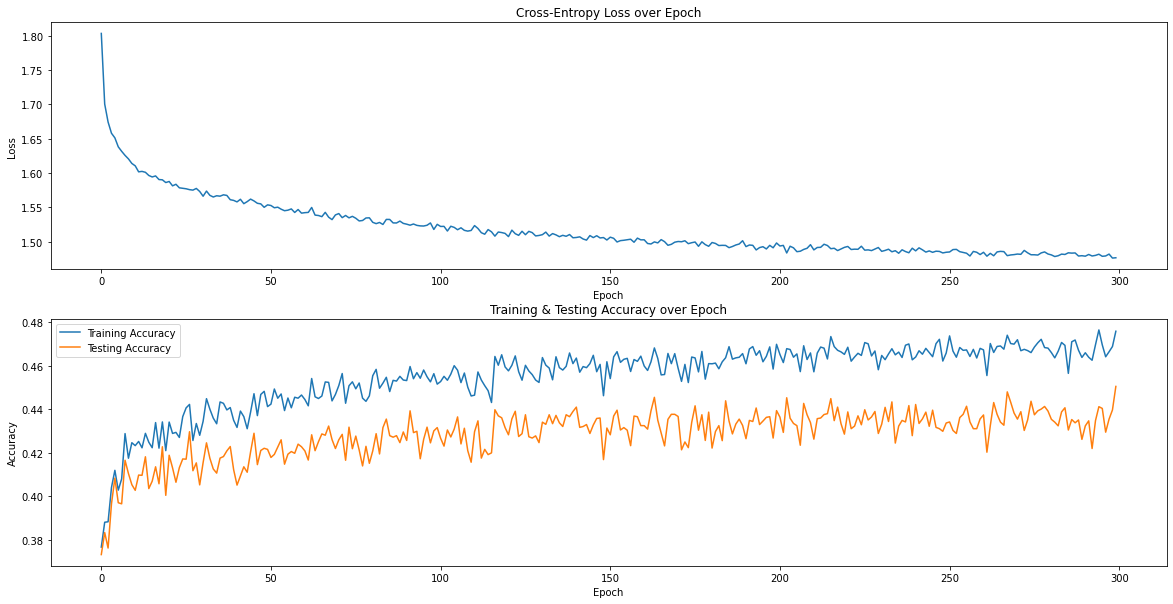

In [16]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
ax[0].plot(trial1['Training Loss'])
ax[0].title.set_text("Cross-Entropy Loss over Epoch")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(trial1['Training Accuracy'], label = "Training Accuracy")
ax[1].plot(trial1['Testing Accuracy'], label = "Testing Accuracy")
ax[1].title.set_text("Training & Testing Accuracy over Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

In [17]:
# Perform prediction of the test dataset
test_df.predictions = nn.predict(test_df.X)
train_df.predictions = nn.predict(train_df.X)
test_df.predictions = test_df.decode(test_df.predictions)
train_df.predictions = train_df.decode(train_df.predictions)

In [18]:
# Confusion Matrix
CM = Utils.create_confusion_mat(test_df)
CM

,0,1,2,3,4,5,6,7,8,9
0,520,67,92,33,49,25,15,55,172,54
1,54,514,27,26,13,19,17,26,68,196
2,74,18,323,90,165,84,82,52,19,18
3,30,31,90,289,80,227,86,68,34,30
4,35,6,132,60,311,53,82,88,25,9
5,24,14,79,188,42,308,61,92,21,19
6,27,24,124,167,189,132,581,61,16,37
7,24,31,66,52,100,92,31,476,14,30
8,146,65,25,31,26,21,14,12,554,75
9,66,230,42,64,25,39,31,70,77,532


In [19]:
#Performance Metrics/Measures
measures = Utils.confusion_mat_measures(CM)
measures

,Precision,Recall,F1
Label,,,
0,0.480591,0.520,0.499520
1,0.535417,0.514,0.524490
2,0.349189,0.323,0.335584
3,0.299482,0.289,0.294148
4,0.388265,0.311,0.345364
5,0.363208,0.308,0.333333
6,0.427835,0.581,0.492791
7,0.519651,0.476,0.496868
8,0.571723,0.554,0.562722


In [29]:
# Accuracy & Performance Metrics
test_accuracy = np.sum(test_df.predictions == test_df.y[:, 0]) / test_df.predictions.shape[0]
train_accuracy = np.sum(train_df.predictions == train_label[:, 0]) / train_df.predictions.shape[0]
F1_avg = measures['F1'].mean()
CELoss = trial1['Training Loss'][-1]
print(f'Final Cross-Entropy Training Loss: {round(CELoss, 4)}.')
print(f'Final Train accuracy: {round(train_accuracy * 100, 4)}%.')
print(f'Final Test accuracy: {round(test_accuracy * 100, 4)}%.')
print(f'Final Average F1 Score: {round(F1_avg, 4)}.')

Final Cross-Entropy Training Loss: 1.4764.
Final Train accuracy: 47.574%.
Final Test accuracy: 44.08%.
Final Average F1 Score: 0.4374.
